# Credit Approval Tutorial
This tutorial illustrates the use of several methods in the AI Explainability 360 Toolkit  to provide different kinds of explanations suited to different users in the context of a credit approval process enabled by machine learning. We use data from the [FICO Explainable Machine Learning Challenge](https://community.fico.com/s/explainable-machine-learning-challenge) as [described below](#intro). The three types of users (a.k.a. consumers) that we consider are a data scientist, who evaluates the machine learning model before deployment, a loan officer, who makes the final decision based on the model's output, and a bank customer, who wants to understand the reasons for their application result. 

For the [data scientist](#rule-based-models), we present two directly interpretable rule-based models that provide global understanding of their behavior. These models are produced by the [Boolean Rule Column Generation](#BRCG) (BRCG, class `BooleanRuleCG`) and [Logistic Rule Regression](#LogRR) (LogRR, class `LogisticRuleRegression`) algorithms in AIX360. The former yields very simple OR-of-ANDs classification rules while the latter gives weighted combinations of rules that are more accurate and still interpretable.

For the [loan officer](#prototypes), we demonstrate a different way of explaining machine learning predictions by showing examples, specifically _prototypes_ or representatives in the training data that are similar to a given loan applicant and receive the same class label. We use the ProtoDash method (class `ProtodashExplainer`) to find these prototypes.

For the [bank customer](#contrastive), we consider the Contrastive Explanations Method (CEM, class `CEMExplainer`) for explaining the predictions of black box models to end users. CEM builds upon the popular approach of highlighting features present in the input instance that are responsible for the model's classification. In addition to these, CEM also identifies features that are (minimally) absent in the input instance, but whose presence would have altered the classification.

The tutorial is organized around these three types of consumers, following an introduction to the dataset.
1. [Introduction to FICO HELOC Dataset](#intro)
2. [Data Scientist: Boolean Rules and Logistic Rule Regression models](#rule-based-models)
3. [Loan Officer: Similar samples as explanations for predictions based on HELOC Dataset](#prototypes)
4. [Customer: Contrastive Explanations for predictions based on HELOC Dataset](#contrastive)

<a name="intro"></a>
## 1. Introduction to FICO HELOC Dataset

The FICO HELOC dataset contains anonymized information about home equity line of credit (HELOC) applications made by real homeowners. A HELOC is a line of credit typically offered by a US bank as a percentage of home equity (the difference between the current market value of a home and the outstanding balance of all liens, e.g. mortgages). The customers in this dataset have requested a credit line in the range of USD 5,000 - 150,000. The machine learning task we are considering is to use the information about the applicant in their credit report to predict whether they will make timely payments over a two year period. The machine learning prediction can then be used to decide whether the homeowner qualifies for a line of credit and, if so, how much credit should be extended. 

The HELOC dataset and more information about it, including instructions to download, can be found [here](https://community.fico.com/s/explainable-machine-learning-challenge?tabset-3158a=2).

The table below reproduces part of the data dictionary that comes with the HELOC dataset, explaining the predictor variables and target variable. For example, NumSatisfactoryTrades is a predictor variable that counts the number of past credit agreements with the applicant, which resulted in on-time payments. The target variable to predict is a binary variable called RiskPerformance. The value “Bad” indicates that an applicant was 90 days past due or worse at least once over a period of 24 months from when the credit account was opened. The value “Good” indicates that they have made their payments without ever being more than 90 days overdue. The relationship between a predictor variable and the target is indicated in the last column of the table. If a predictor variable is monotonically decreasing with respect to probability of bad = 1, it 
means that as the value of the variable increases, the probability of the loan application being "Bad" decreases, i.e. it becomes more "good". For example, ExternalRiskEstimate and NumSatisfactoryTrades are shown as monotonically decreasing. Monotonically increasing has the opposite meaning.


|Field | Meaning |Monotonicity Constraint (with respect to probability of bad = 1)|
|------|---------|----------------------------------------------------------------|
|ExternalRiskEstimate |	Consolidated version of risk markers |Monotonically Decreasing| 
|MSinceOldestTradeOpen	| Months Since Oldest Trade Open | Monotonically Decreasing|
|MSinceMostRecentTradeOpen | Months Since Most Recent Trade Open |Monotonically Decreasing
|AverageMInFile	| Average Months in File |Monotonically Decreasing|
|NumSatisfactoryTrades |	Number Satisfactory Trades |Monotonically Decreasing|
|NumTrades60Ever2DerogPubRec |	Number Trades 60+ Ever |Monotonically Decreasing|
|NumTrades90Ever2DerogPubRec | Number Trades 90+ Ever |Monotonically Decreasing| 
|PercentTradesNeverDelq	| Percent Trades Never Delinquent|Monotonically Decreasing|
|MSinceMostRecentDelq	| Months Since Most Recent Delinquency|Monotonically Decreasing|
|MaxDelq2PublicRecLast12M |	Max Delq/Public Records Last 12 Months. See tab "MaxDelq" for each category|Values 0-7 are monotonically decreasing|
|MaxDelqEver |	Max Delinquency Ever. See tab "MaxDelq" for each category|Values 2-8 are monotonically decreasing|
|NumTotalTrades	| Number of Total Trades (total number of credit accounts)|No constraint|
|NumTradesOpeninLast12M	| Number of Trades Open in Last 12 Months|Monotonically Increasing| 
|PercentInstallTrades	| Percent Installment Trades|No constraint|
|MSinceMostRecentInqexcl7days |	Months Since Most Recent Inq excl 7days|Monotonically Decreasing| 
|NumInqLast6M	| Number of Inq Last 6 Months|Monotonically Increasing|
|NumInqLast6Mexcl7days	| Number of Inq Last 6 Months excl 7days. Excluding the last 7 days removes inquiries that are likely due to price comparision shopping. |Monotonically Increasing|
|NetFractionRevolvingBurden	| Net Fraction Revolving Burden. This is revolving balance divided by credit limit |Monotonically Increasing|
|NetFractionInstallBurden	| Net Fraction Installment Burden. This is installment balance divided by original loan amount |Monotonically Increasing| 
|NumRevolvingTradesWBalance	| Number Revolving Trades with Balance |No constraint|
|NumInstallTradesWBalance	| Number Installment Trades with Balance |No constraint|
|NumBank2NatlTradesWHighUtilization	| Number Bank/Natl Trades w high utilization ratio |Monotonically Increasing|
|PercentTradesWBalance	| Percent Trades with Balance |No constraint
|RiskPerformance	| Paid as negotiated flag (12-36 Months). String of Good and Bad | Target |


#### Storing HELOC dataset to run this notebook
- In this notebook, we assume that the HELOC dataset is saved as `./aix360/data/heloc_data/heloc_dataset.csv`, where "." is the root directory of the Git repository before running a pip install of aix360 library. 
- If the data is downloaded after installation, please place the file within the respective folder under site-packages of your virtual environment `path-to-your-virtual-env/lib/python3.6/site-packages/aix360/data/heloc_data/heloc_dataset.csv`


<a name="rule-based-models"></a>
## 2. Data scientist: Boolean Rule and Logistic Rule Regression models
In evaluating a machine learning model for deployment, a data scientist would ideally like to understand the behavior of the model as a whole, not just in specific instances (e.g. specific loan applicants). This is especially true in regulated industries such as banking where higher standards of explainability may be required. For example, the data scientist may have to present the model to: 1) technical and business managers for review before deployment, 2) a lending expert to compare the model to the expert's knowledge, or 3) a regulator to check for compliance. Furthermore, it is common for a model to be deployed in a different geography than the one it was trained on. A global view of the model may uncover problems with overfitting and poor generalization to other geographies before deployment.

Directly interpretable models can provide such global understanding because they have a sufficiently simple form for their workings to be transparent. Below we present two directly interpretable models in the form of a [Boolean rule (BR)](#BRCG) and a [logistic rule regression (LogRR)](#LogRR) model. The former is produced by the Boolean Rule Column Generation (BRCG) algorithm while the latter is a generalized linear rule model (GLRM), both implemented in AIX360. While both models are interpretable, they provide different trade-offs between model simplicity and accuracy in predicting loan repayment. BRCG yields a very simple set of rules that has reasonable accuracy. LogRR achieves higher accuracy, higher even than some uninterpretable models, while retaining the form of a linear model. Its interpretation is enhanced by [plots as demonstrated below](#visualize).

### 2.1. Load and process data for BRCG and LogRR
We use the `HELOCDataset` class in AIX360 to load the FICO HELOC data as a DataFrame. The setting `custom_preprocessing=nan_preprocessing` converts special values in the data (coded as negative integers) to `np.nan`, which can be handled properly by BRCG and LogRR, as opposed to replacing them with zeros or mean values. The data is then split into training and test sets using a fixed random seed.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Load FICO HELOC data with special values converted to np.nan
from aix360.datasets.heloc_dataset import HELOCDataset, nan_preprocessing
data = HELOCDataset(custom_preprocessing=nan_preprocessing).data()
# Separate target variable
y = data.pop('RiskPerformance')

# Split data into training and test sets using fixed random seed
from sklearn.model_selection import train_test_split
dfTrain, dfTest, yTrain, yTest = train_test_split(data, y, random_state=0, stratify=y)
dfTrain.head().transpose()

Using TensorFlow backend.


Using Heloc dataset:  /Users/vijay/DEVJAN22/AIX360/aix360/datasets/../data/heloc_data/heloc_dataset.csv


,8960,8403,1949,4886,4998
ExternalRiskEstimate,64.0,57.0,59.0,65.0,65.0
MSinceOldestTradeOpen,175.0,47.0,168.0,228.0,117.0
MSinceMostRecentTradeOpen,6.0,9.0,3.0,5.0,7.0
AverageMInFile,97.0,35.0,38.0,69.0,48.0
NumSatisfactoryTrades,29.0,5.0,21.0,24.0,7.0
NumTrades60Ever2DerogPubRec,9.0,1.0,0.0,3.0,1.0
NumTrades90Ever2DerogPubRec,9.0,0.0,0.0,2.0,1.0
PercentTradesNeverDelq,63.0,50.0,100.0,85.0,78.0
MSinceMostRecentDelq,2.0,16.0,NaN,3.0,36.0
MaxDelq2PublicRecLast12M,4.0,6.0,7.0,0.0,6.0


BRCG and LogRR require non-binary features to be binarized using the provided `FeatureBinarizer` class. We use the default of nine quantile thresholds (i.e. 10 bins) to binarize ordinal (including continuous-valued) features, include all negations (e.g. '>' comparisons as well as '<='), and also return standardized versions of the original unbinarized ordinal features, which are used by LogRR but not BRCG. Below is the result of binarizing the first 'ExternalRiskEstimate' feature. 

In [2]:
# Binarize data and also return standardized ordinal features
from aix360.algorithms.rbm import FeatureBinarizer
fb = FeatureBinarizer(negations=True, returnOrd=True)
dfTrain, dfTrainStd = fb.fit_transform(dfTrain)
dfTest, dfTestStd = fb.transform(dfTest)
dfTrain['ExternalRiskEstimate'].head()

operation   <=                                            >                 \
value     59.0 63.0 66.0 69.0 72.0 75.0 78.0 82.0 86.0 59.0 63.0 66.0 69.0   
8960         0    0    1    1    1    1    1    1    1    1    1    0    0   
8403         1    1    1    1    1    1    1    1    1    0    0    0    0   
1949         1    1    1    1    1    1    1    1    1    0    0    0    0   
4886         0    0    1    1    1    1    1    1    1    1    1    0    0   
4998         0    0    1    1    1    1    1    1    1    1    1    0    0   

operation                           ==  !=  
value     72.0 75.0 78.0 82.0 86.0 NaN NaN  
8960         0    0    0    0    0   0   1  
8403         0    0    0    0    0   0   1  
1949         0    0    0    0    0   0   1  
4886         0    0    0    0    0   0   1  
4998         0    0    0    0    0   0   1

<a name="BRCG"></a>
### 2.2. Run Boolean Rule Column Generation (BRCG)
First we consider BRCG, which is designed to produce a very simple OR-of-ANDs rule (known more formally as disjunctive normal form, DNF) or alternatively an AND-of-ORs rule (conjunctive normal form, CNF) to predict whether an applicant will repay the loan on time (Y = 1). For a binary classification problem such as we have here, a DNF rule is equivalent to a *rule set*, where AND clauses in the DNF correspond to individual rules in the rule set. Furthermore, it can be shown that a CNF rule for Y = 1 is equivalent to a DNF rule for Y = 0 [[1]](https://ieeexplore.ieee.org/document/7738856). BRCG is distinguished by its use of the optimization technique of column generation to search the space of possible clauses, which is exponential in size. To learn more about column generation, please see our NeurIPS paper [[2]](http://papers.nips.cc/paper/7716-boolean-decision-rules-via-column-generation). 

For this dataset, we find that a CNF rule for Y = 1 (i.e. a DNF for Y = 0, enabled by setting `CNF=True`) is slightly better than a DNF rule for Y = 1. The model complexity parameters `lambda0` and `lambda1` penalize the number of clauses in the rule and the number of conditions in each clause. We use the default values of 1e-3 for `lambda0` and `lambda1` (decreasing them did not increase accuracy here) and leave other parameters at their defaults as well. The model is then trained, evaluated, and printed.

In [3]:
# Instantiate BRCG with small complexity penalty and large beam search width
from aix360.algorithms.rbm import BooleanRuleCG
br = BooleanRuleCG(lambda0=1e-3, lambda1=1e-3, CNF=True)

# Train, print, and evaluate model
br.fit(dfTrain, yTrain)
from sklearn.metrics import accuracy_score
print('Training accuracy:', accuracy_score(yTrain, br.predict(dfTrain)))
print('Test accuracy:', accuracy_score(yTest, br.predict(dfTest)))
print('Predict Y=0 if ANY of the following rules are satisfied, otherwise Y=1:')
print(br.explain()['rules'])

Learning CNF rule with complexity parameters lambda0=0.001, lambda1=0.001
Initial LP solved
Iteration: 1, Objective: 0.2895
Iteration: 2, Objective: 0.2895
Iteration: 3, Objective: 0.2895
Iteration: 4, Objective: 0.2895
Iteration: 5, Objective: 0.2864
Iteration: 6, Objective: 0.2864
Iteration: 7, Objective: 0.2864
Training accuracy: 0.719573146021883
Test accuracy: 0.696515397082658
Predict Y=0 if ANY of the following rules are satisfied, otherwise Y=1:
['ExternalRiskEstimate <= 75.00 AND NumSatisfactoryTrades <= 17.00', 'ExternalRiskEstimate <= 72.00 AND NumSatisfactoryTrades > 17.00']


The returned DNF rule for Y = 0 is indeed very simple with only two clauses, each involving the same two features. It is interesting to see that such a rule can already achieve 69.7% accuracy. 'ExternalRiskEstimate' is a consolidated version of some risk markers (higher is better), while 'NumSatisfactoryTrades' is the number of satisfactory credit accounts. It makes sense therefore that for applicants with more than 17 satisfactory accounts, the ExternalRiskEstimate threshold dividing good (Y = 1) and bad (Y = 0) credit risk is slightly lower (more lenient) than for applicants with fewer satisfactory accounts.

We note that AIX360 includes only a heuristic beam search version of BRCG. The published version of BRCG [[2]](http://papers.nips.cc/paper/7716-boolean-decision-rules-via-column-generation) (not implemented in AIX360) uses integer programming to yield slightly more complex rules that are also more accurate (close to 72% test accuracy).

<a name="LogRR"></a>
### 2.3. Run Logistic Rule Regression (LogRR)
Next we consider a LogRR model, which can improve accuracy at the cost of a more complex but still interpretable model. Specifically, LogRR fits a logistic regression model using rule-based features, where column generation is again used to generate promising candidates from the space of all possible rules. Here we are also including unbinarized ordinal features (`useOrd=True`) in addition to rules. Similar to BRCG, the complexity parameters `lambda0`, `lambda1` penalize the number of rules included in the model and the number of conditions in each rule. the The values for `lambda0`, `lambda1` below strike a good balance between accuracy and model complexity, based on our published experience with the FICO HELOC dataset [[3]](http://proceedings.mlr.press/v97/wei19a.html).

In [4]:
# Instantiate LRR with good complexity penalties and numerical features
from aix360.algorithms.rbm import LogisticRuleRegression
lrr = LogisticRuleRegression(lambda0=0.005, lambda1=0.001, useOrd=True)

# Train, print, and evaluate model
lrr.fit(dfTrain, yTrain, dfTrainStd)
print('Training accuracy:', accuracy_score(yTrain, lrr.predict(dfTrain, dfTrainStd)))
print('Test accuracy:', accuracy_score(yTest, lrr.predict(dfTest, dfTestStd)))
print('Probability of Y=1 is predicted as logistic(z) = 1 / (1 + exp(-z))')
print('where z is a linear combination of the following rules/numerical features:')
lrr.explain()

Training accuracy: 0.7426718897744158
Test accuracy: 0.7260940032414911
Probability of Y=1 is predicted as logistic(z) = 1 / (1 + exp(-z))
where z is a linear combination of the following rules/numerical features:


,rule/numerical feature,coefficient
0,(intercept),-0.129693
1,MSinceMostRecentInqexcl7days > 0.00,0.680256
2,ExternalRiskEstimate,0.654176
3,NetFractionRevolvingBurden,-0.554147
4,NumSatisfactoryTrades,0.551635
5,NumInqLast6M,-0.463194
6,NumBank2NatlTradesWHighUtilization,-0.448368
7,AverageMInFile <= 52.00,-0.43437
8,NumRevolvingTradesWBalance <= 5.00,0.421518
9,MaxDelq2PublicRecLast12M <= 5.00,-0.418161


The test accuracy of LogRR is significantly better than that of BRCG and even better than the neural network in the [Loan Officer](#c2) and [Customer](#contrastive) sections. The LogRR model remains directly interpretable as it is a logistic regression model that uses the 36 rule-based and ordinal features shown above (in addition to an intercept term). Rules are distinguished by having one or more conditions on feature values (e.g. AverageMInFile <= 52.0) while ordinal features are marked by just the feature name without conditions (e.g. ExternalRiskEstimate). Being a linear model, feature importance is naturally given by the model coefficients and thus the list is sorted in order of decreasing coefficient magnitude. The list can be truncated if the user wishes to display fewer features.

Since the rules in this LogRR model happen to all be single conditions on individual features, the model contains no interactions between features. It is therefore a kind of [generalized additive model (GAM)](https://en.wikipedia.org/wiki/Generalized_additive_model), i.e. a sum of functions of individual features, where these functions are themselves sums of step function components from rules and linear components from unbinarized ordinal features. Thus a better way to visualize the model is by plotting the univariate functions that make up the GAM, as we do next.

<a name="visualize"></a>
### 2.4. Visualize LogRR model as a Generalized Additive Model (GAM)
We use the `visualize()` method of `LogisticRuleRegression` to plot the functions in the GAM that corresponds to the LogRR model (more generally, `visualize()` plots the GAM part of a LogRR model, excluding higher-degree rules). The plots show the sizes and shapes of the model's dependences on individual features. These can then be compared to a lending expert's knowledge. In the present case, all plots indicate that the model behaves as we would expect with some interesting nuances. 

The 36 features shown above involve only 14 of the original features in the data (not including the intercept), as verified below. For example, ExternalRiskEstimate appears in its unbinarized form in row 2 above and also in 3 rules (rows 14, 23, 34).

In [5]:
dfx = lrr.explain()
# Separate 1st-degree rules into (feature, operation, value) to count unique features
dfx2 = dfx['rule/numerical feature'].str.split(' ', expand=True)
dfx2.columns = ['feature','operation','value']
dfx2['feature'].nunique() # includes intercept

15

It follows that there are 14 functions to plot, which we organize into semantic groups below to ease interpretation.

#### ExternalRiskEstimate
As expected from the BRCG Boolean rule above, 'ExternalRiskEstimate' is an important feature positively correlated with good credit risk. The jumps in the plot indicate that applicants with above average 'ExternalRiskEstimate' (the mean is 72) get an additional boost.

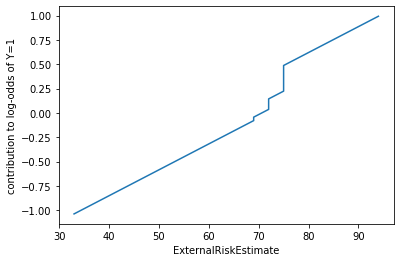

In [6]:
lrr.visualize(data, fb, ['ExternalRiskEstimate']);

#### Credit inquiries
The next two plots illustrate the dependence on the applicant's credit inquiries. The first plot shows a significant penalty for having less than one month since the most recent inquiry ('MSinceMostRecentInqexcl7days' = 0).

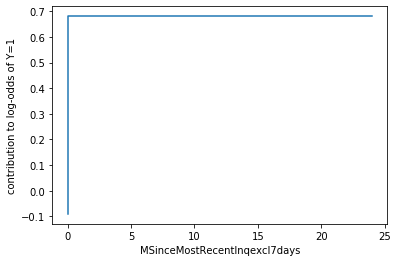

In [7]:
lrr.visualize(data, fb, ['MSinceMostRecentInqexcl7days']);

The second shows that predicted risk increases with the number of inquiries in the last six months ('NumInqLast6M').

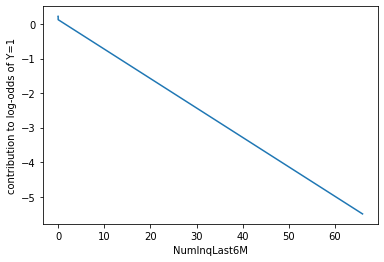

In [8]:
lrr.visualize(data, fb, ['NumInqLast6M']);

#### Debt level
The following four plots relate to the applicant's debt level. 'NetFractionRevolvingBurden' is the ratio of revolving debt (e.g. credit card) balance to credit limit, expressed as a percentage, and has a large negative impact on the probability of good credit. A small fraction of applicants (less than 1%) actually have NetFractionRevolvingBurden greater than 100%, i.e. more revolving debt than their credit limit. This might be investigated further by the data scientist.

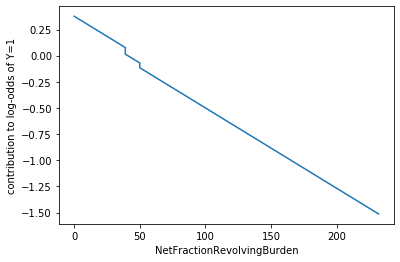

In [9]:
lrr.visualize(data, fb, ['NetFractionRevolvingBurden']);

The second 'NumBank2NatlTradesWHighUtilization' plot shows that the number of accounts ("trades") with high utilization (high balance relative to credit limit for each account) also has a large impact, with a drop as soon as one account has high utilization.

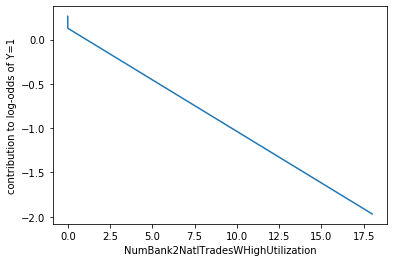

In [10]:
lrr.visualize(data, fb, ['NumBank2NatlTradesWHighUtilization']);

 The third plot shows that the model gives a bonus to applicants who carry balances on no more than five revolving debt accounts.

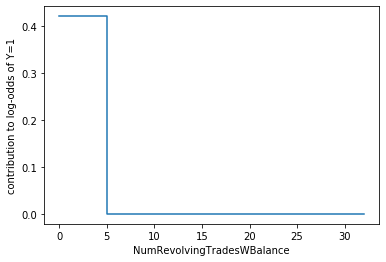

In [11]:
lrr.visualize(data, fb, ['NumRevolvingTradesWBalance']);

The fourth shows an effect from the percentage of accounts with a balance that is much smaller than those from other features.

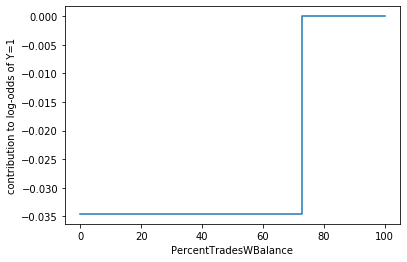

In [12]:
lrr.visualize(data, fb, ['PercentTradesWBalance']);

#### Number and type of accounts
The number of "satisfactory" accounts ("trades") has a significant positive effect on the predicted probability of good credit, with jumps at 12 and 17 accounts.

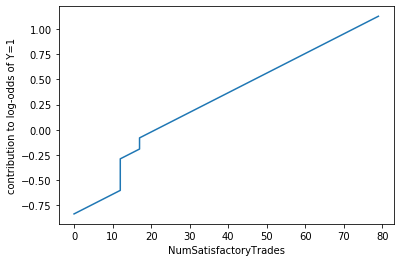

In [13]:
lrr.visualize(data, fb, ['NumSatisfactoryTrades']);

However, having more than 40% as installment debt accounts (e.g. car loans) is seen as a negative.

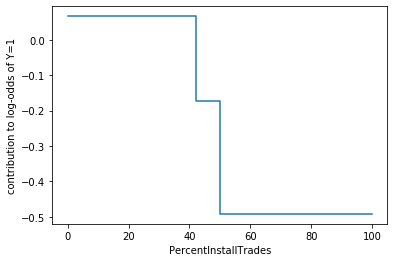

In [14]:
lrr.visualize(data, fb, ['PercentInstallTrades']);

#### Length of credit history
The 'AverageMInFile' plot shows that most of the benefit of having a longer average credit history accrues between average ages of 52 and 84 months (four to seven years). 

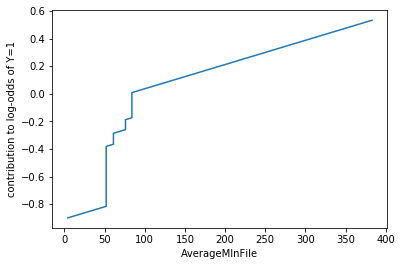

In [15]:
lrr.visualize(data, fb, ['AverageMInFile']);

Similar but smaller gains come when the age of the oldest account ('MSinceOldestTradeOpen') exceeds 122 and 146 months (10-12 years).

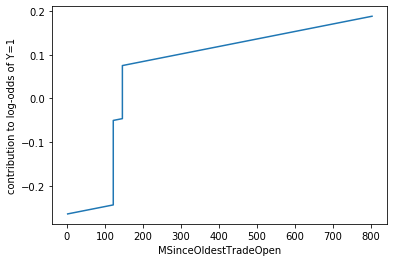

In [16]:
lrr.visualize(data, fb, ['MSinceOldestTradeOpen']);

#### Delinquencies
The last set of plots looks at the effect of delinquencies. The first plot shows that much of the change due to the percentage of accounts that were never delinquent ('PercentTradesNeverDelq') occurs between 90% and 100%.

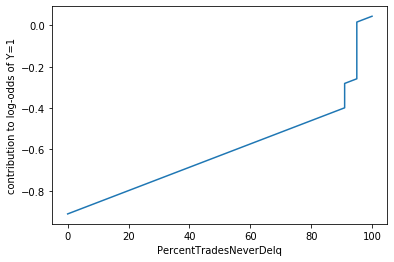

In [17]:
lrr.visualize(data, fb, ['PercentTradesNeverDelq']);

'MaxDelq2PublicRecLast12M' measures the severity of the applicant's worst delinquency from the last 12 months of the public record. A value of 5 or below indicates that some delinquency has occurred, whether of unknown duration, 30/60/90/120 days delinquent, or a derogatory comment. 

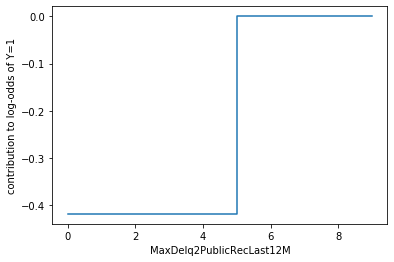

In [18]:
lrr.visualize(data, fb, ['MaxDelq2PublicRecLast12M']);

According to the last 'MSinceMostRecentDelq' plot, the effect of the most recent delinquency wears off after 21 months.

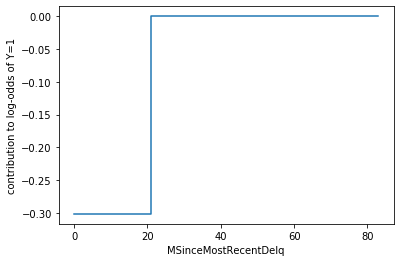

In [19]:
lrr.visualize(data, fb, ['MSinceMostRecentDelq']);

<a name="prototypes"></a>
## 3. Loan Officer: Prototypical explanations for HELOC use case

We now show how to generate explanations in the form of selecting prototypical or similar user profiles to an applicant in question that a bank employee such as a loan officer may be interested in. This may help the employee understand the decision of an applicant's HELOC application being accepted or rejected in the context of other similar applications. Note that the selected prototypical applications are profiles that are part of the training set that has been used to train an AI model that predicts good or bad i.e. approved or rejected for these applications. In fact, the method used in this notebook can work even if we are given not just one but a set of user profiles for which we want to find similar profiles from a training dataset. Additionally, the method computes weights for each prototype showcasing its similarity to the user(s) in question.

The prototypical explanations in AIX360 are obtained using the Protodash algorithm developed in the following work: [ProtoDash: Fast Interpretable Prototype Selection](https://arxiv.org/abs/1707.01212)

We now provide a brief overview of the method. The method takes as input a datapoint (or group of datapoints) that we want to explain with respect to instances in a training set belonging to the same feature space. The method then tries to minimize the maximum mean discrepancy (MMD metric) between the datapoints we want to explain and a prespecified number of instances from the training set that it will select. In other words, it will try to select training instances that have the same distribution as the datapoints we want to explain. The method does greedy selection and has quality guarantees with it also returning importance weights for the chosen prototypical training instances indicative of how similar/representative they are.

In this tutorial, we will see two examples of obtaining prototypes, one for a user whose HELOC application was approved and another for a user whose HELOC application was rejected. In each case, we showcase the top five prototypes from the training data along with how similar the feature values were for these prototypes.

[Example 1. Obtaining similar samples as explanations for a HELOC applicant predicted as "Good"](#good)<br>
[Example 2. Obtaining similar samples as explanations for a HELOC applicant predicted as "Bad"](#bad)<br>


###### Why Protodash?
Before we showcase the two examples we provide some motivation for using this method. The method selects applications from the training set that are similar in different ways to the user application we want to explain. For example, a users loan may be rejected justifiably because the number of satisfactory trades he performed were low similar to another rejected user, or because his/her debts were too high similar to a different rejected user. Either of these reasons in isolation may be sufficient for rejection and the method is able to surface a variety of such reasons through the selected prototypes. This is not the case using standard nearest neighbor techniques which use metrics such as euclidean distance, cosine similarity amongst others, where one might get the same type of explanation (i.e. applications with only low number of satisfactory trades). Protodash thus is able to provide a much more well rounded and comprehensive view of why the decision for the applicant may be justifiable.

Another benefit of the method is that — since it does distribution matching between the user/users in question and those available in the training set — it could, in principle, be applied also in non-iid settings such as for time series data. Other approaches which find similar profiles using standard distance measures (viz. euclidean, cosine) do not have this property. Additionally, we can also highlight important features for the different prototypes that made them similar to the user/users in question.


### Import statements

Import necessary libraries, frameworks and algorithms.

In [20]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Dense
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from aix360.algorithms.contrastive import CEMExplainer, KerasClassifier
from aix360.algorithms.protodash import ProtodashExplainer
from aix360.datasets.heloc_dataset import HELOCDataset

### Load HELOC dataset and show sample applicants

In [21]:
heloc = HELOCDataset()
df = heloc.dataframe()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 24)
pd.set_option('display.width', 1000)
print("Size of HELOC dataset:", df.shape)
print("Number of \"Good\" applicants:", np.sum(df['RiskPerformance']=='Good'))
print("Number of \"Bad\" applicants:", np.sum(df['RiskPerformance']=='Bad'))
print("Sample Applicants:")
df.head(10).transpose()

Using Heloc dataset:  /Users/vijay/DEVJAN22/AIX360/aix360/datasets/../data/heloc_data/heloc_dataset.csv
Size of HELOC dataset: (10459, 24)
Number of "Good" applicants: 5000
Number of "Bad" applicants: 5459
Sample Applicants:


,0,1,2,3,4,5,6,7,8,9
ExternalRiskEstimate,55,61,67,66,81,59,54,68,59,61
MSinceOldestTradeOpen,144,58,66,169,333,137,88,148,324,79
MSinceMostRecentTradeOpen,4,15,5,1,27,11,7,7,2,4
AverageMInFile,84,41,24,73,132,78,37,65,138,36
NumSatisfactoryTrades,20,2,9,28,12,31,25,17,24,19
NumTrades60Ever2DerogPubRec,3,4,0,1,0,0,0,0,0,0
NumTrades90Ever2DerogPubRec,0,4,0,1,0,0,0,0,0,0
PercentTradesNeverDelq,83,100,100,93,100,91,92,83,85,95
MSinceMostRecentDelq,2,-7,-7,76,-7,1,9,31,5,5
MaxDelq2PublicRecLast12M,3,0,7,6,7,4,4,6,4,4


Distribution of ExternalRiskEstimate and NumSatisfactoryTrades columns:


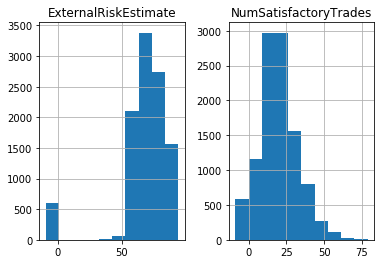

In [22]:
# Plot (example) distributions for two features
print("Distribution of ExternalRiskEstimate and NumSatisfactoryTrades columns:")
hist = df.hist(column=['ExternalRiskEstimate', 'NumSatisfactoryTrades'], bins=10)

<a name="c1"></a>
### Step 1: Process and Normalize HELOC dataset for training

We will first process the HELOC dataset before using it to train an NN model that can predict the
target variable RiskPerformance. The HELOC dataset is a tabular dataset with numerical values. However, some of the values are negative and need to be filtered. The processed data is stored in the file heloc.npz for easy access. The dataset is also normalized for training.

The data processing and the type of model built in this case is different from the Data Scientist persona described above where rule based methods are showcased. This is the reason for going through these steps again for the Loan Officer persona.

#### a. Process the dataset

In [23]:
# Clean data and split dataset into train/test
(Data, x_train, x_test, y_train_b, y_test_b) = heloc.split()



#### b. Normalize the dataset

In [24]:
Z = np.vstack((x_train, x_test))
Zmax = np.max(Z, axis=0)
Zmin = np.min(Z, axis=0)

#normalize an array of samples to range [-0.5, 0.5]
def normalize(V):
    VN = (V - Zmin)/(Zmax - Zmin)
    VN = VN - 0.5
    return(VN)
    
# rescale a sample to recover original values for normalized values. 
def rescale(X):
    return(np.multiply ( X + 0.5, (Zmax - Zmin) ) + Zmin)

N = normalize(Z)
xn_train = N[0:x_train.shape[0], :]
xn_test  = N[x_train.shape[0]:, :]

<a name="c2"></a>
### Step 2. Define and train a NN classifier

Let us now build a loan approval model based on the HELOC dataset.

#### a. Define NN architecture
We now define the architecture of a 2-layer neural network classifier whose predictions we will try to interpret. 

In [25]:
# nn with no softmax
def nn_small():
    model = Sequential()
    model.add(Dense(10, input_dim=23, kernel_initializer='normal', activation='relu'))
    model.add(Dense(2, kernel_initializer='normal'))    
    return model    

#### b. Train the NN

In [26]:
# Set random seeds for repeatability
np.random.seed(1) 
tf.set_random_seed(2) 

class_names = ['Bad', 'Good']

# loss function
def fn(correct, predicted):
    return tf.nn.softmax_cross_entropy_with_logits(labels=correct, logits=predicted)

# compile and print model summary
nn = nn_small()
nn.compile(loss=fn, optimizer='adam', metrics=['accuracy'])
nn.summary()


# train model or load a trained model
TRAIN_MODEL = False

if (TRAIN_MODEL): 
    nn.fit(xn_train, y_train_b, batch_size=128, epochs=500, verbose=1, shuffle=False)
    nn.save_weights("heloc_nnsmall.h5")     
else:    
    nn.load_weights("heloc_nnsmall.h5")
        

# evaluate model accuracy        
score = nn.evaluate(xn_train, y_train_b, verbose=0) #Compute training set accuracy
#print('Train loss:', score[0])
print('Train accuracy:', score[1])

score = nn.evaluate(xn_test, y_test_b, verbose=0) #Compute test set accuracy
#print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                240       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
Total params: 262
Trainable params: 262
Non-trainable params: 0
_________________________________________________________________

Train accuracy: 0.7387545704841614
Test accuracy: 0.7224473357200623


<a name="good"></a>
### Step 3: Obtain similar samples as explanations for a HELOC applicant predicted as "Good" (Example 1)

#### a. Normalize the data and chose a particular applicant, whose profile is displayed below.

In [27]:
p_train = nn.predict_classes(xn_train) # Use trained neural network to predict train points
p_train = p_train.reshape((p_train.shape[0],1))

z_train = np.hstack((xn_train, p_train)) # Store (normalized) instances that were predicted as Good
z_train_good = z_train[z_train[:,-1]==1, :]

zun_train = np.hstack((x_train, p_train)) # Store (unnormalized) instances that were predicted as Good 
zun_train_good = zun_train[zun_train[:,-1]==1, :]

Let us now consider applicant 8 whose loan was approved. Note that this applicant was also considered for the contrastive explainer, however, we now justify the approved status in a different manner using prototypical examples, which is arguably a better explanation for a bank employee.

In [28]:
idx = 8

X = xn_test[idx].reshape((1,) + xn_test[idx].shape)

print("Chosen Sample:", idx)
print("Prediction made by the model:", class_names[np.argmax(nn.predict_proba(X))])
print("Prediction probabilities:", nn.predict_proba(X))
print("")

# attach the prediction made by the model to X
X = np.hstack((X, nn.predict_classes(X).reshape((1,1))))

Xun = x_test[idx].reshape((1,) + x_test[idx].shape) 
dfx = pd.DataFrame.from_records(Xun.astype('double')) # Create dataframe with original feature values
dfx[23] = class_names[int(X[0, -1])]
dfx.columns = df.columns
dfx.transpose()


Chosen Sample: 8
Prediction made by the model: Good
Prediction probabilities: [[-0.1889221   0.29527372]]



,0
ExternalRiskEstimate,82
MSinceOldestTradeOpen,280
MSinceMostRecentTradeOpen,13
AverageMInFile,102
NumSatisfactoryTrades,22
NumTrades60Ever2DerogPubRec,0
NumTrades90Ever2DerogPubRec,0
PercentTradesNeverDelq,91
MSinceMostRecentDelq,26
MaxDelq2PublicRecLast12M,6


#### b. Find similar applicants predicted as "good" using the protodash explainer. 

In [29]:
explainer = ProtodashExplainer()
(W, S, setValues) = explainer.explain(X, z_train_good, m=5) # Return weights W, Prototypes S and objective function values

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  1.8207e+01 -2.2985e+05  5e+01  1e+00  1e+00
 2: -1.6771e+00 -1.4132e+06  3e+02  1e+00  1e+00
 3:  6.4653e-01 -7.7669e+06  2e+03  1e+00  1e+00
 4:  9.0963e-01 -1.6930e+08  3e+04  1e+00  1e+00
 5:  6.8400e-01 -8.7461e+10  2e+07  1e+00  1e+00
 6:  2.1065e+08 -1.7700e+18  2e+18  3e-13  8e-03
 7:  2.1065e+08 -1.7700e+16  2e+16  3e-15  1e-03
 8:  2.1065e+08 -1.7700e+14  2e+14  1e-16  3e-05
 9:  2.1065e+08 -1.7706e+12  2e+12  6e-17  1e-07
10:  2.1059e+08 -1.8270e+10  2e+10  3e-16  3e-09
11:  2.0548e+08 -7.3263e+08  9e+08  1e-16  4e-09
12:  5.4547e+06 -5.0769e+08  5e+08  2e-16  4e-10
13:  2.4579e+06 -1.0151e+07  1e+07  3e-16  1e-11
14:  3.9731e+05 -4.8259e+05  9e+05  8e-17  6e-13
15:  5.6807e+04 -6.2926e+04  1e+05  1e-16  2e-13
16:  8.0641e+03 -9.1700e+03  2e+04  3e-16  1e-14
17:  1.1237e+03 -1.3430e+03  2e+03  4e-16  1e-14
18:  1.4817e+02 -2.0491e+02  4e+02  2e-16  8e-15
19:  1.5650e+01 -3.45

#### c. Display similar applicant user profiles and the extent to which they are similar to the chosen applicant as indicated by the last row in the table below labelled as "Weight".

In [30]:
dfs = pd.DataFrame.from_records(zun_train_good[S, 0:-1].astype('double'))
RP=[]
for i in range(S.shape[0]):
    RP.append(class_names[int(z_train_good[S[i], -1])]) # Append class names
dfs[23] = RP
dfs.columns = df.columns  
dfs["Weight"] = np.around(W, 5)/np.sum(np.around(W, 5)) # Calculate normalized importance weights
dfs.transpose()

,0,1,2,3,4
ExternalRiskEstimate,85,89,77,83,73
MSinceOldestTradeOpen,223,379,338,789,230
MSinceMostRecentTradeOpen,13,156,2,6,5
AverageMInFile,87,257,109,102,89
NumSatisfactoryTrades,23,3,16,41,61
NumTrades60Ever2DerogPubRec,0,0,2,0,0
NumTrades90Ever2DerogPubRec,0,0,2,0,0
PercentTradesNeverDelq,91,100,90,100,100
MSinceMostRecentDelq,26,0,65,0,0
MaxDelq2PublicRecLast12M,6,7,6,7,6


#### d. Compute how similar a feature of a prototypical user is to the chosen applicant.
The more similar the feature of prototypical user is to the applicant, the closer its weight is to 1. We can see below that several features for prototypes are quite similar to the chosen applicant. A human friendly explanation is provided thereafter.

In [31]:
z = z_train_good[S, 0:-1] # Store chosen prototypes
eps = 1e-10 # Small constant defined to eliminate divide-by-zero errors
fwt = np.zeros(z.shape)
for i in range (z.shape[0]):
    for j in range(z.shape[1]):
        fwt[i, j] = np.exp(-1 * abs(X[0, j] - z[i,j])/(np.std(z[:, j])+eps)) # Compute feature similarity in [0,1]
                
# move wts to a dataframe to display
dfw = pd.DataFrame.from_records(np.around(fwt.astype('double'), 2))
dfw.columns = df.columns[:-1]
dfw.transpose()        

,0,1,2,3,4
ExternalRiskEstimate,0.59,0.29,0.42,0.84,0.21
MSinceOldestTradeOpen,0.76,0.62,0.76,0.09,0.79
MSinceMostRecentTradeOpen,1.00,0.09,0.83,0.89,0.87
AverageMInFile,0.79,0.09,0.90,1.00,0.82
NumSatisfactoryTrades,0.95,0.39,0.74,0.39,0.15
NumTrades60Ever2DerogPubRec,1.00,1.00,0.08,1.00,1.00
NumTrades90Ever2DerogPubRec,1.00,1.00,0.08,1.00,1.00
PercentTradesNeverDelq,1.00,0.15,0.81,0.15,0.15
MSinceMostRecentDelq,1.00,0.36,0.22,0.36,0.36
MaxDelq2PublicRecLast12M,1.00,0.13,1.00,0.13,1.00


#### Explanation:
The above table depicts the five closest user profiles to the chosen applicant. Based on importance weight outputted by the method, we see that the prototype under column zero is the most representative user profile by far. This is (intuitively) confirmed from the feature similarity table above where more than 50% of the features (12 out of 23) of this prototype are identical to that of the chosen user whose prediction we want to explain. Also, the bank employee looking at the prototypical users and their features surmises that the approved applicant belongs to a group of approved users that have practically no debt (NetFractionInstallBurden). This justification gives the employee more confidence in approving the users application.


<a name="bad"></a>
### Example 2. Obtaining similar samples as explanations for a HELOC applicant predicted as "Bad". 
We now consider a user 1272 whose loan was denied. We obtained a contrastive explanation for this user before. Similar to user 8, we now obtain exemplar based explanations for this user to help the bank employee understand the reasons for the rejection. Steps similar to example 1 are followed in this case too, where we first process the data, obtain prototypes and their importance weights, and finally showcase how similar the features are of these prototypes to the user we want to explain.

#### a. Normalize the data and chose a particular applicant, whose profile is displayed below.

In [32]:
z_train_bad = z_train[z_train[:,-1]==0, :]
zun_train_bad = zun_train[zun_train[:,-1]==0, :]

In [33]:
idx = 1272 #another user to try 2385

X = xn_test[idx].reshape((1,) + xn_test[idx].shape)
print("Chosen Sample:", idx)
print("Prediction made by the model:", class_names[np.argmax(nn.predict_proba(X))])
print("Prediction probabilities:", nn.predict_proba(X))
print("")

X = np.hstack((X, nn.predict_classes(X).reshape((1,1))))

# move samples to a dataframe to display
Xun = x_test[idx].reshape((1,) + x_test[idx].shape)
dfx = pd.DataFrame.from_records(Xun.astype('double'))
dfx[23] = class_names[int(X[0, -1])]
dfx.columns = df.columns
dfx.transpose()

Chosen Sample: 1272
Prediction made by the model: Bad
Prediction probabilities: [[ 0.40682057 -0.391679  ]]



,0
ExternalRiskEstimate,65
MSinceOldestTradeOpen,256
MSinceMostRecentTradeOpen,15
AverageMInFile,52
NumSatisfactoryTrades,17
NumTrades60Ever2DerogPubRec,0
NumTrades90Ever2DerogPubRec,0
PercentTradesNeverDelq,100
MSinceMostRecentDelq,0
MaxDelq2PublicRecLast12M,7


#### b. Find similar applicants predicted as "bad" using the protodash explainer. 

In [34]:
(W, S, setValues) = explainer.explain(X, z_train_bad, m=5) # Return weights W, Prototypes S and objective function values

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  1.3951e+01 -1.8757e+05  4e+01  1e+00  1e+00
 2: -1.0452e+00 -2.4808e+06  5e+02  1e+00  1e+00
 3:  9.9094e-01 -3.7820e+07  8e+03  1e+00  1e+00
 4:  1.2044e+00 -5.7710e+09  1e+06  1e+00  1e+00
 5:  1.6105e+08 -1.3427e+17  1e+17  6e-13  3e-04
 6:  1.6105e+08 -1.3427e+15  1e+15  6e-15  2e-04
 7:  1.6105e+08 -1.3427e+13  1e+13  2e-16  2e-06
 8:  1.6104e+08 -1.3473e+11  1e+11  1e-16  6e-08
 9:  1.6063e+08 -1.8053e+09  2e+09  6e-18  1e-09
10:  1.2950e+08 -3.8084e+08  5e+08  5e-17  7e-10
11:  6.9589e+06 -2.2750e+08  2e+08  2e-16  4e-12
12:  2.4924e+06 -4.9489e+06  7e+06  1e-16  8e-13
13:  3.7960e+05 -4.1688e+05  8e+05  2e-16  0e+00
14:  5.4362e+04 -6.0989e+04  1e+05  1e-16  1e-13
15:  7.7281e+03 -8.7442e+03  2e+04  1e-16  5e-14
16:  1.0814e+03 -1.2777e+03  2e+03  2e-16  2e-14
17:  1.4452e+02 -1.9320e+02  3e+02  2e-16  6e-15
18:  1.6236e+01 -3.1901e+01  5e+01  2e-16  3e-15
19:  7.9417e-02 -6.57

#### c. Display similar applicant user profiles and the extent to which they are similar to the chosen applicant as indicated by the last row in the table below labelled as "Weight".

In [35]:
# move samples to a dataframe to display
dfs = pd.DataFrame.from_records(zun_train_bad[S, 0:-1].astype('double'))
RP=[]
for i in range(S.shape[0]):
    RP.append(class_names[int(z_train_bad[S[i], -1])]) # Append class names
dfs[23] = RP
dfs.columns = df.columns  
dfs["Weight"] = np.around(W, 5)/np.sum(np.around(W, 5)) # Compute normalized importance weights for prototypes
dfs.transpose()

,0,1,2,3,4
ExternalRiskEstimate,73,61,64,55,0
MSinceOldestTradeOpen,191,125,85,194,383
MSinceMostRecentTradeOpen,17,7,0,26,383
AverageMInFile,53,32,13,100,383
NumSatisfactoryTrades,19,5,2,18,1
NumTrades60Ever2DerogPubRec,0,1,0,0,1
NumTrades90Ever2DerogPubRec,0,1,0,0,1
PercentTradesNeverDelq,100,100,100,84,100
MSinceMostRecentDelq,0,0,0,1,0
MaxDelq2PublicRecLast12M,7,7,7,4,6


#### d. Compute how similar a feature of a prototypical user is to the chosen applicant.
The more similar the feature of prototypical user is to the applicant, the closer its weight is to 1. We can see below that several features for prototypes are quite similar to the chosen applicant. Following this table we provide human friendly explanation based on this table.

In [36]:
z = z_train_bad[S, 0:-1] # Store the prototypes
eps = 1e-10 # Small constant to guard against divide by zero errors
fwt = np.zeros(z.shape)
for i in range (z.shape[0]): # Compute feature similarity for each prototype
    for j in range(z.shape[1]):
        fwt[i, j] = np.exp(-1 * abs(X[0, j] - z[i,j])/(np.std(z[:, j])+eps))
                
# move wts to a dataframe to display
dfw = pd.DataFrame.from_records(np.around(fwt.astype('double'), 2))
dfw.columns = df.columns[:-1]
dfw.transpose()        

,0,1,2,3,4
ExternalRiskEstimate,0.73,0.86,0.96,0.68,0.08
MSinceOldestTradeOpen,0.53,0.28,0.19,0.55,0.29
MSinceMostRecentTradeOpen,0.99,0.95,0.90,0.93,0.08
AverageMInFile,0.99,0.86,0.75,0.70,0.09
NumSatisfactoryTrades,0.78,0.22,0.15,0.88,0.13
NumTrades60Ever2DerogPubRec,1.00,0.13,1.00,1.00,0.13
NumTrades90Ever2DerogPubRec,1.00,0.13,1.00,1.00,0.13
PercentTradesNeverDelq,1.00,1.00,1.00,0.08,1.00
MSinceMostRecentDelq,1.00,1.00,1.00,0.08,1.00
MaxDelq2PublicRecLast12M,1.00,1.00,1.00,0.08,0.42


#### Explanation:
Here again, the above table depicts the five closest user profiles to the chosen applicant. Based on importance weight outputted by the method we see that the prototype under column zero is the most representative user profile by far. This is (intuitively) confirmed from the feature similarity table above where 10 features out of 23 of this prototype are highly similar (>0.9) to that of the user we want to explain. Also the bank employee can see that the applicant belongs to a group of rejected applicants with similar deliquency behavior. Realizing that the user also poses similar risk as these other applicants whose loan was rejected, the employee takes the more conservative decision of rejecting the users application as well.

<a name="contrastive"></a>
## 4. Customer: Contrastive explanations for HELOC Use Case

We now demonstrate how to compute contrastive explanations using AIX360 and how such explanations can help home owners understand the decisions made by AI models that approve or reject their HELOC applications. 

Typically, home owners would like to understand why they do not qualify for a line of credit and if so what changes in their application would qualify them. On the other hand, if they qualified, they might want to know what factors led to the approval of their application. 

In this context, contrastive explanations provide information to applicants about what minimal changes to their profile would have changed the decision of the AI model from reject to accept or vice-versa (_pertinent negatives_). For example, increasing the number of satisfactory trades to a certain value may have led to the acceptance of the application everything else being the same. 

The method presented here also highlights a minimal set of features and their values that would still maintain the original decision (_pertinent positives_). For example, for an applicant whose HELOC application was approved, the 
explanation may say that even if the number of satisfactory trades was reduced to a lower number, the loan would have still gotten through.

Additionally, organizations (Banks, financial institutions, etc.) would like to understand trends in the behavior of their AI models in approving loan applications, which could be done by studying contrastive explanations for individuals whose loans were either accepted or rejected. Looking at the aggregate statistics of pertinent positives for approved applicants the organization can get insight into what minimal set of features and their values play an important role in acceptances. While studying the aggregate statistics of pertinent negatives the organization can get insight into features that could change the status of rejected applicants and potentially uncover ways that an applicant may game the system by changing potentially non-important features that could alter the models outcome. 

The contrastive explanations in AIX360 are implemented using the algorithm developed in the following work:
###### [Explanations based on the Missing: Towards Contrastive Explanations with Pertinent Negatives](https://arxiv.org/abs/1802.07623)

We now provide a brief overview of the method. As mentioned above the algorithm outputs a contrastive explanation which consists of two parts: a) pertinent negatives (PNs) and b) pertinent positives (PPs). PNs identify a minimal set of features which if altered would change the classification of the original input. For example, in the loan case if a person's credit score is increased their loan application status may change from reject to accept. The manner in which the method accomplishes this is by optimizing a change in the prediction probability loss while enforcing an elastic norm constraint that results in minimal change of features and their values. Optionally, an auto-encoder may also be used to force these minimal changes to produce realistic PNs. PPs on the other hand identify a minimal set of features and their values that are sufficient to yield the original input's classification. For example, an individual's loan may still be accepted if the salary was 50K as opposed to 100K. Here again we have an elastic norm term so that the amount of information needed is minimal, however, the first loss term in this case tries to make the original input's class to be the winning class. For a more in-depth discussion, please refer to the above work.


The three main steps to obtain a contrastive explanation are shown below. The first two steps are more about processing the data and building an AI model while the third step computes the actual explanation. 

 [Step 1. Process and Normalize HELOC dataset for training](#c1)<br>
 [Step 2. Define and train a NN classifier](#c2)<br>
 [Step 3. Compute contrastive explanations for a few applicants](#c3)<br>


### Load HELOC dataset and show sample applicants

In [37]:
import warnings
warnings.filterwarnings('ignore')

heloc = HELOCDataset()
df = heloc.dataframe()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 24)
pd.set_option('display.width', 1000)
print("Size of HELOC dataset:", df.shape)
print("Number of \"Good\" applicants:", np.sum(df['RiskPerformance']=='Good'))
print("Number of \"Bad\" applicants:", np.sum(df['RiskPerformance']=='Bad'))
print("Sample Applicants:")
df.head(10).transpose()

Using Heloc dataset:  /Users/vijay/DEVJAN22/AIX360/aix360/datasets/../data/heloc_data/heloc_dataset.csv
Size of HELOC dataset: (10459, 24)
Number of "Good" applicants: 5000
Number of "Bad" applicants: 5459
Sample Applicants:


,0,1,2,3,4,5,6,7,8,9
ExternalRiskEstimate,55,61,67,66,81,59,54,68,59,61
MSinceOldestTradeOpen,144,58,66,169,333,137,88,148,324,79
MSinceMostRecentTradeOpen,4,15,5,1,27,11,7,7,2,4
AverageMInFile,84,41,24,73,132,78,37,65,138,36
NumSatisfactoryTrades,20,2,9,28,12,31,25,17,24,19
NumTrades60Ever2DerogPubRec,3,4,0,1,0,0,0,0,0,0
NumTrades90Ever2DerogPubRec,0,4,0,1,0,0,0,0,0,0
PercentTradesNeverDelq,83,100,100,93,100,91,92,83,85,95
MSinceMostRecentDelq,2,-7,-7,76,-7,1,9,31,5,5
MaxDelq2PublicRecLast12M,3,0,7,6,7,4,4,6,4,4


Distribution of ExternalRiskEstimate and NumSatisfactoryTrades columns:


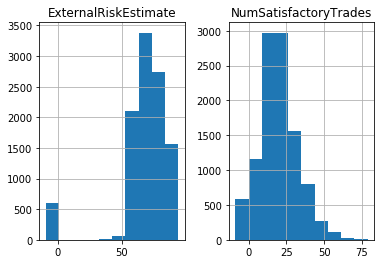

In [38]:
# Plot (example) distributions for two features
print("Distribution of ExternalRiskEstimate and NumSatisfactoryTrades columns:")
hist = df.hist(column=['ExternalRiskEstimate', 'NumSatisfactoryTrades'], bins=10)

<a name="c1"></a>
### Step 1. Process and Normalize HELOC dataset for training

We will first process the HELOC dataset before using it to train an NN model that can predict the
target variable RiskPerformance. The HELOC dataset is a tabular dataset with numerical values. However, some of the values are negative and need to be filtered. The processed data is stored in the file heloc.npz for easy access. The dataset is also normalized for training.

The data processing and model building is very similar to the Loan Officer persona above, where ProtoDash was the method of choice. We repeat these steps here so that both the use cases can be run independently.

#### a. Process the dataset

In [39]:
# Clean data and split dataset into train/test
PROCESS_DATA = False

if (PROCESS_DATA): 
    (Data, x_train, x_test, y_train_b, y_test_b) = heloc.split()
    np.savez('heloc.npz', Data=Data, x_train=x_train, x_test=x_test, y_train_b=y_train_b, y_test_b=y_test_b)
else:
    heloc = np.load('heloc.npz', allow_pickle = True)
    Data = heloc['Data']
    x_train = heloc['x_train']
    x_test  = heloc['x_test']
    y_train_b = heloc['y_train_b']
    y_test_b  = heloc['y_test_b']



#### b. Normalize the dataset

In [40]:
Z = np.vstack((x_train, x_test))
Zmax = np.max(Z, axis=0)
Zmin = np.min(Z, axis=0)

#normalize an array of samples to range [-0.5, 0.5]
def normalize(V):
    VN = (V - Zmin)/(Zmax - Zmin)
    VN = VN - 0.5
    return(VN)
    
# rescale a sample to recover original values for normalized values. 
def rescale(X):
    return(np.multiply ( X + 0.5, (Zmax - Zmin) ) + Zmin)

N = normalize(Z)
xn_train = N[0:x_train.shape[0], :]
xn_test  = N[x_train.shape[0]:, :]

<a name="c2"></a>
### Step 2. Define and train a NN classifier

Let us now build a loan approval model based on the HELOC dataset.

#### a. Define NN architecture
We now define the architecture of a 2-layer neural network classifier whose predictions we will try to interpret. 

In [41]:
# nn with no softmax
def nn_small():
    model = Sequential()
    model.add(Dense(10, input_dim=23, kernel_initializer='normal', activation='relu'))
    model.add(Dense(2, kernel_initializer='normal'))    
    return model    

#### b. Train the NN

In [42]:
# Set random seeds for repeatability
np.random.seed(1) 
tf.set_random_seed(2) 

class_names = ['Bad', 'Good']

# loss function
def fn(correct, predicted):
    return tf.nn.softmax_cross_entropy_with_logits(labels=correct, logits=predicted)

# compile and print model summary
nn = nn_small()
nn.compile(loss=fn, optimizer='adam', metrics=['accuracy'])
nn.summary()


# train model or load a trained model
TRAIN_MODEL = False

if (TRAIN_MODEL):             
    nn.fit(xn_train, y_train_b, batch_size=128, epochs=500, verbose=1, shuffle=False)
    nn.save_weights("heloc_nnsmall.h5")     
else:    
    nn.load_weights("heloc_nnsmall.h5")
        

# evaluate model accuracy        
score = nn.evaluate(xn_train, y_train_b, verbose=0) #Compute training set accuracy
#print('Train loss:', score[0])
print('Train accuracy:', score[1])

score = nn.evaluate(xn_test, y_test_b, verbose=0) #Compute test set accuracy
#print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                240       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 22        
Total params: 262
Trainable params: 262
Non-trainable params: 0
_________________________________________________________________
Train accuracy: 0.7387545704841614
Test accuracy: 0.7224473357200623


<a name="c3"></a>
### Step 3. Compute contrastive explanations for a few applicants

Given the trained NN model to decide on loan approvals, let us first examine an applicant whose application was denied and what (minimal) changes to his/her application would lead to approval (i.e. finding pertinent negatives). We will then look at another applicant whose loan was approved and ascertain features that would minimally suffice in him/her still getting a positive outcome (i.e. finding pertinent positives).

#### a. Compute Pertinent Negatives (PN): 

In order to compute pertinent negatives, the CEM explainer computes a user profile that is close to the original applicant but for whom the decision of HELOC application is different. The explainer alters a minimal set of features by a minimal (positive) amount. This will help the user whose loan application was initially rejected say, to ascertain how to get it accepted. 

In [43]:
# Some interesting user samples to try: 2344 449 1168 1272
idx = 1272

X = xn_test[idx].reshape((1,) + xn_test[idx].shape)
print("Computing PN for Sample:", idx)
print("Prediction made by the model:", nn.predict_proba(X))
print("Prediction probabilities:", class_names[np.argmax(nn.predict_proba(X))])
print("")

mymodel = KerasClassifier(nn)
explainer = CEMExplainer(mymodel)

arg_mode = 'PN' # Find pertinent negatives
arg_max_iter = 1000 # Maximum number of iterations to search for the optimal PN for given parameter settings
arg_init_const = 10.0 # Initial coefficient value for main loss term that encourages class change
arg_b = 9 # No. of updates to the coefficient of the main loss term
arg_kappa = 0.1 # Minimum confidence gap between the PNs (changed) class probability and original class' probability
arg_beta = 1e-1 # Controls sparsity of the solution (L1 loss)
arg_gamma = 100 # Controls how much to adhere to a (optionally trained) auto-encoder
my_AE_model = None # Pointer to an auto-encoder

# Find PN for applicant 1272
(adv_pn, delta_pn, info_pn) = explainer.explain_instance(X, arg_mode, my_AE_model, arg_kappa, arg_b,
                                                         arg_max_iter, arg_init_const, arg_beta, arg_gamma)

Computing PN for Sample: 1272
Prediction made by the model: [[ 0.40682057 -0.391679  ]]
Prediction probabilities: Bad




Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

iter:0 const:[10.]
Loss_Overall:0.2935, Loss_Attack:0.0000
Loss_L2Dist:0.2065, Loss_L1Dist:0.8703, AE_loss:0.0
target_lab_score:-1.1559, max_nontarget_lab_score:1.3184

iter:500 const:[10.]
Loss_Overall:0.1687, Loss_Attack:0.0000
Loss_L2Dist:0.1139, Loss_L1Dist:0.5485, AE_loss:0.0
target_lab_score:-0.7303, max_nontarget_lab_score:0.8571

iter:0 const:[5.]
Loss_Overall:0.0668, Loss_Attack:0.0000
Loss_L2Dist:0.0368, Loss_L1Dist:0.3000, AE_loss:0.0
target_lab_score:-0.2295, max_nontarget_lab_score:0.3076

iter:500 const:[5.]
Loss_Overall:1.5487, Loss_Attack:1.5277
Loss_L2Dist:0.0085, Loss_L1Dist:0.1243, AE_loss:0.0
target_lab_score:0.1245, max_nontarget_lab_score:-0.0810

iter:0 const:[2.5]
Loss_Ov

Let us start by examining one particular loan application that was denied for applicant 1272. We showcase below how the decision could have been different through minimal changes to the profile conveyed by the pertinent negative. We also indicate the importance of different features to produce the change in the application status. The column delta in the table below indicates the necessary deviations for each of the features to produce this change. A human friendly explanation is then provided based on these deviations following the feature importance plot.

In [44]:
Xpn = adv_pn
classes = [ class_names[np.argmax(nn.predict_proba(X))], class_names[np.argmax(nn.predict_proba(Xpn))], 'NIL' ]

print("Sample:", idx)
print("prediction(X)", nn.predict_proba(X), class_names[np.argmax(nn.predict_proba(X))])
print("prediction(Xpn)", nn.predict_proba(Xpn), class_names[np.argmax(nn.predict_proba(Xpn))] )


X_re = rescale(X) # Convert values back to original scale from normalized
Xpn_re = rescale(Xpn)
Xpn_re = np.around(Xpn_re.astype(np.double), 2)

delta_re = Xpn_re - X_re
delta_re = np.around(delta_re.astype(np.double), 2)
delta_re[np.absolute(delta_re) < 1e-4] = 0

X3 = np.vstack((X_re, Xpn_re, delta_re))

dfre = pd.DataFrame.from_records(X3) # Create dataframe to display original point, PN and difference (delta)
dfre[23] = classes

dfre.columns = df.columns
dfre.rename(index={0:'X',1:'X_PN', 2:'(X_PN - X)'}, inplace=True)
dfret = dfre.transpose()


def highlight_ce(s, col, ncols):
    if (type(s[col]) != str):
        if (s[col] > 0):
            return(['background-color: yellow']*ncols)    
    return(['background-color: white']*ncols)

dfret.style.apply(highlight_ce, col='(X_PN - X)', ncols=3, axis=1) 

Sample: 1272
prediction(X) [[ 0.40682057 -0.391679  ]] Bad
prediction(Xpn) [[-0.02118406  0.07892033]] Good


,X,X_PN,(X_PN - X)
ExternalRiskEstimate,65,76.37,11.37
MSinceOldestTradeOpen,256,256,0
MSinceMostRecentTradeOpen,15,15,0
AverageMInFile,52,64.81,12.81
NumSatisfactoryTrades,17,20.3,3.3
NumTrades60Ever2DerogPubRec,0,0,0
NumTrades90Ever2DerogPubRec,0,0,0
PercentTradesNeverDelq,100,100,0
MSinceMostRecentDelq,0,0,0
MaxDelq2PublicRecLast12M,7,7,0


Now let us compute the importance of different PN features that would be instrumental in 1272 receiving a favorable outcome and display below.

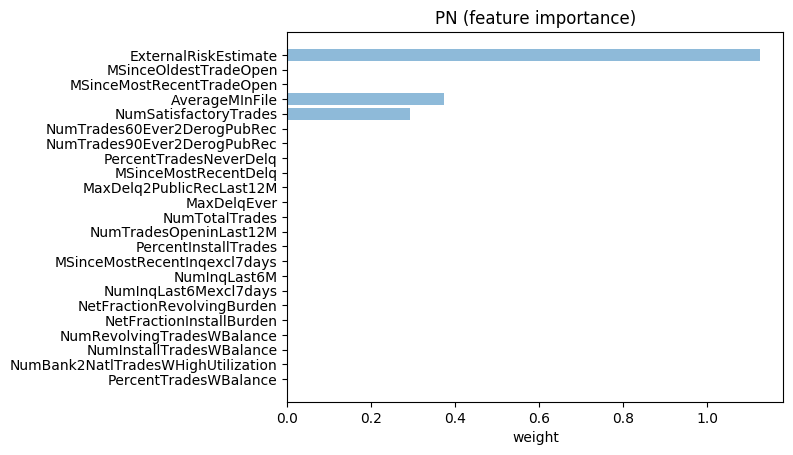

In [45]:
plt.rcdefaults()
fi = abs((X-Xpn).astype('double'))/np.std(xn_train.astype('double'), axis=0) # Compute PN feature importance
objects = df.columns[-2::-1]
y_pos = np.arange(len(objects))
performance = fi[0, -1::-1]

plt.barh(y_pos, performance, align='center', alpha=0.5) # bar chart
plt.yticks(y_pos, objects) # Display features on y-axis
plt.xlabel('weight') # x-label
plt.title('PN (feature importance)') # Heading

plt.show() # Display PN feature importance

#### Explanation:  
We observe that the applicant 1272's loan application would have been accepted if the consolidated risk marker score  (i.e. ExternalRiskEstimate) increased from 65 to 76, the loan application was on file (i.e. AverageMlnFile) for about 65 months and if the number of satisfactory trades (i.e. NumSatisfactoryTrades) increased to little over 20.

_The above changes to the three suggested factors are also intuitively consistent in improving the chances of acceptance of an application, since all three are monotonic with probability of acceptance (refer HELOC description table). 
However, one must realize that the above explanation is for the particular applicant based on what the model would do and does not necessarily have to agree with their intuitive meaning. In fact, if the explanation is deemed unacceptable then its an indication that perhaps the model should be debugged/updated_.

#### Compute Pertinent Positives (PP):
In order to compute pertinent positives, the CEM explainer identifies a minimal set of features along with their values (as close to 0) that would still maintain the predicted loan application status of the applicant.

In [46]:
# Some interesting user samples to try: 8 9 11
idx = 8

X = xn_test[idx].reshape((1,) + xn_test[idx].shape)
print("Computing PP for Sample:", idx)
print("Prediction made by the model:", class_names[np.argmax(nn.predict_proba(X))])
print("Prediction probabilities:", nn.predict_proba(X))
print("")


mymodel = KerasClassifier(nn)
explainer = CEMExplainer(mymodel)

arg_mode = 'PP' # Find pertinent positives
arg_max_iter = 1000 # Maximum number of iterations to search for the optimal PN for given parameter settings
arg_init_const = 10.0 # Initial coefficient value for main loss term that encourages class change
arg_b = 9 # No. of updates to the coefficient of the main loss term
arg_kappa = 0.1 # Minimum confidence gap between the PNs (changed) class probability and original class' probability
arg_beta = 1e-1 # Controls sparsity of the solution (L1 loss)
arg_gamma = 100 # Controls how much to adhere to a (optionally trained) auto-encoder
my_AE_model = None # Pointer to an auto-encoder

(adv_pp, delta_pp, info_pp) = explainer.explain_instance(X, arg_mode, my_AE_model, arg_kappa, arg_b,
                                                         arg_max_iter, arg_init_const, arg_beta, arg_gamma)

Computing PP for Sample: 8
Prediction made by the model: Good
Prediction probabilities: [[-0.1889221   0.29527372]]

iter:0 const:[10.]
Loss_Overall:8.1419, Loss_Attack:7.9649
Loss_L2Dist:0.1243, Loss_L1Dist:0.5266, AE_loss:0.0
target_lab_score:-0.3578, max_nontarget_lab_score:0.3387

iter:500 const:[10.]
Loss_Overall:0.8676, Loss_Attack:0.0000
Loss_L2Dist:0.7509, Loss_L1Dist:1.1667, AE_loss:0.0
target_lab_score:0.6813, max_nontarget_lab_score:-0.6306

iter:0 const:[5.]
Loss_Overall:8.4407, Loss_Attack:8.3992
Loss_L2Dist:0.0216, Loss_L1Dist:0.1987, AE_loss:0.0
target_lab_score:-0.8223, max_nontarget_lab_score:0.7575

iter:500 const:[5.]
Loss_Overall:2.9148, Loss_Attack:2.6934
Loss_L2Dist:0.1709, Loss_L1Dist:0.5053, AE_loss:0.0
target_lab_score:-0.2224, max_nontarget_lab_score:0.2163

iter:0 const:[2.5]
Loss_Overall:6.1030, Loss_Attack:6.1013
Loss_L2Dist:0.0002, Loss_L1Dist:0.0149, AE_loss:0.0
target_lab_score:-1.2149, max_nontarget_lab_score:1.1256

iter:500 const:[2.5]
Loss_Overall:6.

For the pertinent positives, we look at a different applicant 8 whose loan application was approved. We want to ascertain here what minimal values for this profile would still have lead to acceptance. Below, we showcase the pertinent positive as well as the important features in maintaining the approved status. The 0s in the PP column indicate that those features were not important. The 0s in the PP column indicate that those features were not important. Here too, we provide a human friendly explanation following the feature importance plot.

In [47]:
Xpp = delta_pp
classes = [ class_names[np.argmax(nn.predict_proba(X))], class_names[np.argmax(nn.predict_proba(Xpp))]]

print("PP for Sample:", idx)
print("Prediction(Xpp) :", class_names[np.argmax(nn.predict_proba(Xpp))])
print("Prediction probabilities for Xpp:", nn.predict_proba(Xpp))
print("")

X_re = rescale(X) # Convert values back to original scale from normalized
adv_pp_re = rescale(adv_pp)
Xpp_re = X_re - adv_pp_re
Xpp_re = np.around(Xpp_re.astype(np.double), 2)
Xpp_re[Xpp_re < 1e-4] = 0

X2 = np.vstack((X_re, Xpp_re))

dfpp = pd.DataFrame.from_records(X2.astype('double')) # Showcase a dataframe for the original point and PP
dfpp[23] = classes
dfpp.columns = df.columns
dfpp.rename(index={0:'X',1:'X_PP'}, inplace=True)
dfppt = dfpp.transpose()

dfppt.style.apply(highlight_ce, col='X_PP', ncols=2, axis=1) 

PP for Sample: 8
Prediction(Xpp) : Good
Prediction probabilities for Xpp: [[-0.04739372  0.06548987]]



,X,X_PP
ExternalRiskEstimate,82,43.38
MSinceOldestTradeOpen,280,0
MSinceMostRecentTradeOpen,13,0
AverageMInFile,102,38.24
NumSatisfactoryTrades,22,7.32
NumTrades60Ever2DerogPubRec,0,0
NumTrades90Ever2DerogPubRec,0,0
PercentTradesNeverDelq,91,0
MSinceMostRecentDelq,26,0
MaxDelq2PublicRecLast12M,6,0


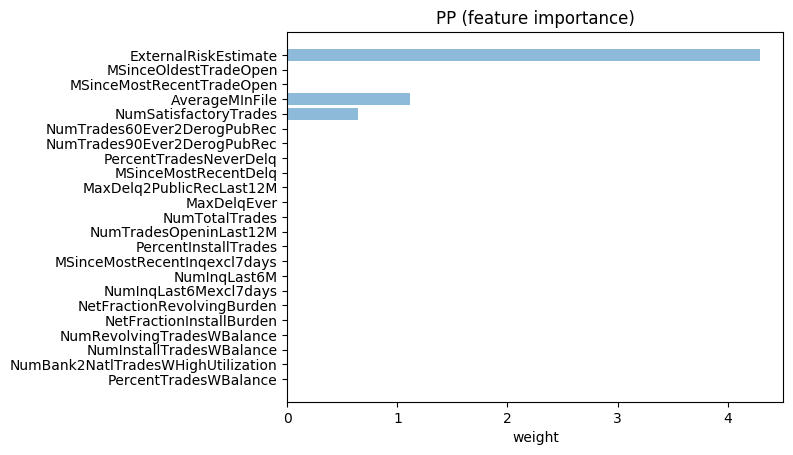

In [48]:
plt.rcdefaults()
fi = abs(Xpp_re.astype('double'))/np.std(x_train.astype('double'), axis=0) # Compute PP feature importance
    
objects = df.columns[-2::-1]
y_pos = np.arange(len(objects)) # Get input feature names
performance = fi[0, -1::-1]

plt.barh(y_pos, performance, align='center', alpha=0.5) # Bar chart
plt.yticks(y_pos, objects) # Plot feature names on y-axis
plt.xlabel('weight') #x-label
plt.title('PP (feature importance)') # Figure heading

plt.show()    # Display the feature importance

#### Explanation:  
We observe that the applicant 8's loan application would still have been accepted even if the consolidated risk marker score (i.e. ExternalRiskEstimate) reduced from 82 to around 40, application was on file (i.e. AverageMlnFile) for close to 70 months and number of satisfactory trades (i.e. NumSatisfactoryTrades) reduced from 22 to almost single digits.

_Note that explanations may change a bit based on equivalent values in a local minima._